# Key Summary

### Mar 1: more parsing
- POS of "NNP" plus "\r\n" parsed pretty well
- Identify the paragraph breakers
- next: parse


### Feb 23 & 24 & 25: proof of concent
- cleanse the code
- calculate the weight of each word in each topic
- visualization on topics across events

### Feb 17 & 19: impliment POS
- using POS seems to be an easier solution to rmove people's name and titles
- <font color='red'>topcis make more sense now</font>
- Next: remain country names
- idea: use (word, pos) to run topic modeling? 

### Feb 15: topic modeling on paragraphs 2019
- **Try paragraph-based topic modeling and <font color='red'>you can see the topcis are different now</font>**
- cleanse the code

### Feb 12: topic modeling on tf-idf files 2015-2019
- Tried tf-idf on all files, didn't work

### Feb 9: topic modeling on wordcount vector files 2015-2019
As discussed on Feb 3, the input of dynamic topic modeling are files, so I postponed parsing transcripts into paragraphs.

- I downloaded all transcripts from 2015-2019 
- First topic modeling result

### Feb 1: parsing files
- Parse fancy files
- the basic unit: each paragraph spoken by one person (i.e. the content divided by dotted line)
- clean those words that are repeated and obviously useless
- Words appeared in the front page and CORPORATE PARTICIPANTS session are repeated and contain no information


### Jan 27 
- I tried different package to read pdf, and pdftotext works best for the transcripts files
- There are two format types. One is fancier. 
- My next step is to parse the fancier files.


### Reference
- Topic Modeling in Python: Latent Dirichlet Allocation (LDA) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- NLTK POS tag list: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/

# Parsing

In [122]:
import pandas as pd
import os
from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

year = 2015
path = os.getcwd() + '\Transcripts' + "\\" + str(year)

# get file names
files = pd.DataFrame(os.listdir(path), columns=["filename"])

# check if it's a fancy(FACTSET) file
files["type"] = files["filename"].map(lambda x: is_FactSet(path + "\\" + x))

# select FactSet files
test = files[ files["type"] == "plain" ].copy()

In [123]:
test

,filename,type
0,20150219_earningcall_2015Q4.pdf,plain
1,20150519_earningcall_2016Q1.pdf,plain
2,20150818_earningcall_2016Q2.pdf,plain
3,20151014_conference.pdf,plain
4,20151117_earningcall_2016Q3.pdf,plain


In [11]:
import pdftotext
import re

In [124]:
filepath = path + "\\" + test["filename"].iloc[3] 
filepath

'C:\\Users\\spong\\Documents\\GitHub\\Capstone-Project\\Transcripts\\2015\\20151014_conference.pdf'

In [125]:
pdfFileObj = open(filepath,'rb')
pdf = pdftotext.PDF(pdfFileObj)
# combine pages
text = "\n\n".join(pdf)
# locate "\r\n" to locate starts of paragraphs later
text = re.sub("\r\n", " WRAPTEXT ",text)

# to_remove
to_remove = [" THOMSON REUTERS STREETEVENTS", " ©2018 Thomson", 
          " Client Id", '\uf0b7', " ©2017 Thomson", " ©2016 Thomson",
           "WAL-MART STORES, INC. COMPANY CONFERENCE PRESENTATION",
            "WAL-MART STORES INC. COMPANY CONFERENCE PRESENTATION ",
            "Thomson Reuters", "Investment Community "]
for item in to_remove:
    text = re.sub(item, " ",text)


In [126]:
# tokenize and tag POS
tokens = nltk.word_tokenize(text)
pos = nltk.pos_tag(tokens)
print(len(tokens))
print(len(pos))
# locate starts of paragraphs
locate = dict()
for i in range(len(pos)-2):
    punctuation = ["•", "’"]
    if pos[i][0] == "WRAPTEXT" and pos[i+1][1] == "NNP" and pos[i+1][0] != "•" and pos[i+2][1] == "NNP"\
    and pos[i+2][0] not in punctuation:
        locate[i] = [pos[i+1], pos[i+2]]
    elif pos[i][0] == "WRAPTEXT" and pos[i+1][1] == "NNP" and pos[i+1][0] not in punctuation and pos[i+2][0] == ":" :
        locate[i] = [pos[i+1], pos[i+2]]
print(len(locate))
locate

32081
32081
161


{0: [('EDITED', 'NNP'), ('TRANSCRIPT', 'NNP')],
 16: [('Community', 'NNP'), ('WRAPTEXT', 'NNP')],
 18: [('EVENT', 'NNP'), ('DATE/TIME', 'NNP')],
 99: [('CORPORATE', 'NNP'), ('PARTICIPANTS', 'NNP')],
 102: [('Pauline', 'NNP'), ('Mohler', 'NNP')],
 114: [('Doug', 'NNP'), ('McMillon', 'NNP')],
 125: [('Charles', 'NNP'), ('Holley', 'NNP')],
 136: [('Neil', 'NNP'), ('Ashe', 'NNP')],
 150: [('Greg', 'NNP'), ('Foran', 'NNP')],
 164: [('CONFERENCE', 'NNP'), ('CALL', 'NNP')],
 168: [('Simeon', 'NNP'), ('Gutman', 'NNP')],
 175: [('Robby', 'NNP'), ('Ohmes', 'NNP')],
 183: [('Paul', 'NNP'), ('Trussell', 'NNP')],
 190: [('Matt', 'NNP'), ('Nemer', 'NNP')],
 198: [('Michael', 'NNP'), ('Lasser', 'NNP')],
 205: [('Bernie', 'NNP'), ('Sosnick', 'NNP')],
 213: [('Matt', 'NNP'), ('Fassler', 'NNP')],
 220: [('Oliver', 'NNP'), ('Chen', 'NNP')],
 228: [('Chris', 'NNP'), ('Horvers', 'NNP')],
 234: [('Greg', 'NNP'), ('Melich', 'NNP')],
 241: [('Dan', 'NNP'), ('Binder', 'NNP')],
 249: [('Peter', 'NNP'), ('Benedi

# Working: topic modeling on paragraphs 2019

In [1]:
import pandas as pd
import os
from itertools import chain
from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

year = 2019
path = os.getcwd() + '\Transcripts' + "\\" + str(year)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# get file names
files = pd.DataFrame(os.listdir(path), columns=["filename"])

# check if it's a fancy(FACTSET) file
files["type"] = files["filename"].map(lambda x: is_FactSet(path + "\\" + x))

# select FactSet files
Factset = files[ files["type"] == "FactSet" ].copy()

# parse all FactSet files and store into a dataframe
#######################################################
### this only applys to FactSet files, need to revise
######################################################
df = filenames_to_para(path, Factset["filename"])

In [289]:
# Factset["date"] = Factset["filename"].map(lambda x: x.split("_")[0])
# Factset["event"] = Factset["filename"].map(lambda x: x.split("_")[1])
# Factset["event"] = Factset["event"].map(lambda x: x.split(".")[0])
# Factset.sort_values(["date"]).to_csv("Factset.csv")

## Preprocessing

In [93]:
df["tokens"] = df["paragraph"].map(nltk.word_tokenize)

# tag Part of Speech
df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)

## to check distribution of POS tags
# df_all_tokens = get_all_wordsPos(df["tokens_pos"])

# filter words with pos not in pos_remaining
pos_remaining = ["NN", "NNS", 
                 "VB", "VBD", "VBN", "VBP", "VBZ"
                ] # take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_remaining])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_clean"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

# remove rows that have no content after lemmatization
df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# remove punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in punctuation])

# remove stop words
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove some specific cases
others = ["'s", "'re", "'ve", "n't", "'ll", "–", "'m"]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in others])

# lower case
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word.lower() for word in x])

df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# # remove short words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)>3])

# # remove long words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)<16])

## Check the POS tag for some key words without filtering

In [84]:
# df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)
# tokens_pos = df["tokens_pos"]
# key_word = "omni"
# check = get_unique_words(tokens_pos)
# check = pd.DataFrame(check)
# check["pos"] = check.index
# check[check["pos"].map(lambda x: key_word in x[0])]

,0,pos
"(omni-channel, JJ)",10,"(omni-channel, JJ)"
"(omnichannel, NN)",10,"(omnichannel, NN)"
"(omnichannel, JJ)",4,"(omnichannel, JJ)"
"(omni-channel, NN)",3,"(omni-channel, NN)"
"(omni, JJ)",2,"(omni, JJ)"
"(omni-offering, NN)",1,"(omni-offering, NN)"
"(omni, RP)",1,"(omni, RP)"
"(omni-retail, NN)",1,"(omni-retail, NN)"
"(omni, NNS)",1,"(omni, NNS)"
"(omni-retail, JJ)",1,"(omni-retail, JJ)"


In [12]:
# # look at unique words to get a sense what needs to be delete
# unique_words = get_unique_words(df["tokens_clean"])

In [94]:
df.shape

(763, 6)

In [95]:
df.apply(lambda x: sum(x.isna()))

paragraph       0
date            0
tokens          0
tokens_pos      0
tokens_clean    0
corpus          0
dtype: int64

In [96]:
sum(df["tokens_clean"].map(lambda x: len(x)<1))

0

## LDA

In [114]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# the input of CountVectorizer is corpe 
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

In [115]:
number_topics = 15
number_words = 10

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)
       
print_topics(lda, count_vectorizer, number_words)


Topic #0:
think year customer store brand talk change see business get

Topic #1:
store grocery get think pickup basket customer lot people manager

Topic #2:
price year think brand customer lot get want sale continue

Topic #3:
seem kind investment ph get format strategy take point wonder

Topic #4:
business market think payment growth customer see ecommerce delivery platform

Topic #5:
question line thank operator proceed come thought consumer conference company

Topic #6:
think thing year change store time say get lot go

Topic #7:
category price think year get cost increase supplier delivery want

Topic #8:
think year business lot continue store see make quarter customer

Topic #9:
get year think say go feel company point way culture

Topic #10:
think customer store get want thing business time go make

Topic #11:
think get business brand thing label time make lot work

Topic #12:
think year look get price bit number business store ticket

Topic #13:
information report offer herei

## Processing after

In [116]:
removing_words = [
    "get", "think", "thing", "know", "kind", "way", "look", "year",
     "question", "guy", "thank", "quarter", "lot", "want", "herein",
    "talk", "guess", "see", "say", "make", "go", "store", "customer",
    "business", "time", "ph", "take", "bit", "work", "morning",
    "company", "mean"
]

df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in removing_words])

In [119]:
## want to filter out rows containing too few words/tokens
df["len_clean"] = df["tokens_clean"].map(len)
sum(df["tokens_clean"].map(lambda x: len(x)<1))

30

In [120]:
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

number_topics = 10

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)
       
number_words = 12
print_topics(lda, count_vectorizer, number_words)


Topic #0:
grocery need pickup basket statement price today investment food point people mix

Topic #1:
sale technology label give leverage come expect brand growth continue product expense

Topic #2:
brand grocery category continue market apparel focus people need capital home online

Topic #3:
delivery price strategy investment pickup cost continue people grocery market learn build

Topic #4:
item opportunity inventory number market growth need use help continue category price

Topic #5:
investment team service side advertising drive ecosystem idea opportunity merchandise help culture

Topic #6:
change price part people assortment space experience gap come feel start competition

Topic #7:
information offer report trademark data investment use guarantee opinion accuracy solicitation advice

Topic #8:
line feel people need team place change operator asset put manager proceed

Topic #9:
people money investment start market grocery today wage need continue part let


In [121]:
words = count_vectorizer.get_feature_names()

for topic in range(0,number_topics):
    topic_vec = lda.components_[topic]
    topic_idx = topic_vec.argsort()[:-10 - 1:-1]
    print("topic:", topic, " ====================")
    for i in topic_idx:
        print('{:<10} {:>10.2%}'.format(words[i], topic_vec[i]/topic_vec.sum()))

topic: 0  ====================
grocery         4.03%
need            2.06%
pickup          1.66%
basket          1.49%
statement       1.41%
price           1.34%
today           1.18%
investment      1.05%
food            0.99%
point           0.82%
topic: 1  ====================
sale            2.43%
technology      1.94%
label           1.38%
give            1.28%
leverage        1.22%
come            1.20%
expect          1.17%
brand           1.14%
growth          1.14%
continue        1.10%
topic: 2  ====================
brand           6.56%
grocery         1.97%
category        1.67%
continue        1.56%
market          1.31%
apparel         1.13%
focus           1.10%
people          1.10%
need            1.04%
capital         0.99%
topic: 3  ====================
delivery        2.74%
price           2.24%
strategy        1.25%
investment      1.15%
pickup          1.11%
cost            0.98%
continue        0.86%
people          0.83%
grocery         0.81%
market          0.

## Check topic for each paragraph

In [152]:
topic_match = lda.transform(count_data)
df["topic"] = [ x.argsort()[-1] + 1 for x in topic_match]

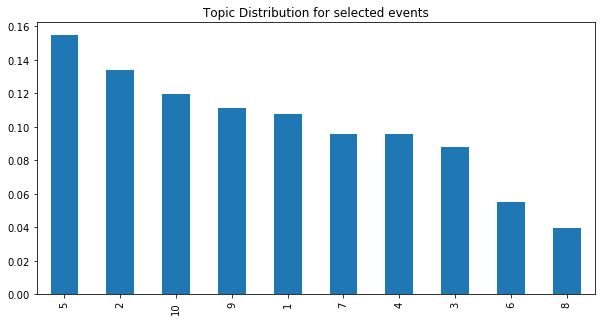

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline  
topic_counts = df["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

Text(0.5, 1.0, 'Topic distribution across events')

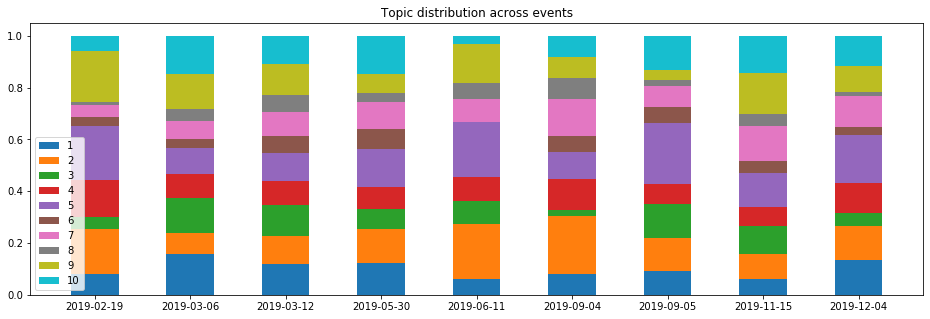

In [156]:
event_tp = df.groupby(by=["date","topic"])["topic"].count().unstack().fillna(0)
tmp = event_tp.T.apply(sum)
event_tp = event_tp.apply(lambda x: x/tmp)
event_tp.index = [str(x)[:10] for x in event_tp.index]

fig, ax = plt.subplots(figsize=(16, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
          'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
bottom = np.array([0]*event_tp.shape[0])
x = event_tp.index.values

for i in event_tp.columns:
#     print(event_tp[i].values)
    plt.bar(x, event_tp[i].values, width=0.5, color=colors[int(i-1)], bottom=bottom)
    bottom = bottom + event_tp[i]

plt.legend(event_tp.columns)
plt.title("Topic distribution across events")

In [158]:
df["date"].value_counts().sort_index()

2019-02-19     86
2019-03-06     88
2019-03-12     75
2019-05-30    212
2019-06-11     33
2019-09-04     49
2019-09-05     77
2019-11-15     83
2019-12-04     60
Name: date, dtype: int64

## Below is work before POS

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(count_data) # the input of TfidfTransformer is a matrix of term/token counts
tf_idf_vector = tfidf_transformer.transform(count_data)

number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(tf_idf_vector)
print_topics(lda, count_vectorizer, number_words)


Topic #0:
barclays karen short capital thank operator proceed line please next

Topic #1:
pile money development house audience 24 replicate degree either india

Topic #2:
sure pleasure true reasonable super specifically fair card india confusing

Topic #3:
michael lasser securities okay balance thanks dastugue quickly idea mean

Topic #4:
stephens bienvenu richard international mayfield paul trussell deutsche thank bank

Topic #5:
officer walmart gregory foran solid carefully flag remember lost anything

Topic #6:
merchandising back great steve bratspies private part category first opportunity

Topic #7:
bank lynch ohmes merrill america robert sorry guy india scott

Topic #8:
information advertising herein provided including 00 bienvenu stephens correct report

Topic #9:
director douglas mcmillon learning decision holiday might current skus assuming


In [8]:
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)      
print_topics(lda, count_vectorizer, number_words)


Topic #0:
information capital short barclays karen including provided herein report without

Topic #1:
pickup delivery basket merchandise seeing term shop serve assortment service

Topic #2:
bank securities paul trussell deutsche guy pretty term sure skus

Topic #3:
technology thank feel pretty sure statement place thanks trying 00

Topic #4:
private label long guy five money even inside probably channel

Topic #5:
private category label world model delivery number space versus important

Topic #6:
stephens bienvenu 00 quarter mean next line first please okay

Topic #7:
sale comp quarter margin product number leverage take billion expense

Topic #8:
commerce 00 feel place always world data program profitability done

Topic #9:
item delivery help million sure 00 feel doug center first


### Previous work

In [4]:
import pdftotext
import os
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline  

def get_text(filepath):
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)
    return(text)

In [2]:
%%time

path = os.getcwd() + '\data\Transcripts'
years = os.listdir(path)

# get all filenames and the text in the files
files = pd.DataFrame()
for year in years:
    filenames = os.listdir(path + "\\" + year)
    filepaths = [path + "\\" + year + "\\" + filename for filename in filenames]
    texts = [get_text(path) for path in filepaths]
    tmp = pd.DataFrame([filenames, texts]).T
    files = pd.concat([files, tmp], ignore_index=True)

files.columns = ["filename", "text"]

Wall time: 4.4 s


In [3]:
%%time
files["tokens"] = files["text"].map(nltk.word_tokenize)
files["tokens_count"] = files["tokens"].map(len)

Wall time: 9.01 s


#### Decide what words to be deleted

In [4]:
from itertools import chain
all_tokens = list(chain.from_iterable(files["tokens"]))
all_tokens = pd.Series(all_tokens)
tokens_count = all_tokens.value_counts()
len(tokens_count)

11937

In [5]:
%%time
unique_tokens = pd.DataFrame()
unique_tokens["token"] = tokens_count.index
unique_tokens["counts"] = tokens_count.values

punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
unique_tokens["punctuation"] = unique_tokens["token"].map(lambda x: x in punctuation)

stop_words = set(stopwords.words('english'))
unique_tokens["stop_words"] = unique_tokens["token"].map(lambda x: x.lower() in stop_words)

unique_tokens["only_twice"] = unique_tokens["counts"].map(lambda x: x <= 2)

unique_tokens["len"] = unique_tokens["token"].map(len)
unique_tokens["too_short"] = unique_tokens["len"] <= 2 # this might eliminate US and UK
unique_tokens["too_long"] = unique_tokens["len"] >= 16 

unique_tokens["apostrophe_comma"] = unique_tokens["token"].map(lambda x: '\'' in x or ',' in x)

removing = (unique_tokens["punctuation"] == True) | (unique_tokens["stop_words"] == True) \
| (unique_tokens["only_twice"] == True) | (unique_tokens["too_short"] == True) \
| (unique_tokens["too_long"] == True) | (unique_tokens["apostrophe_comma"] == True)

remain_token = unique_tokens[~removing]

# remain_token[remain_token["token"].map(lambda x: x[0].isupper())]

removing_words = unique_tokens[removing]["token"]

Wall time: 70.4 ms


In [20]:
len(remain_token)

5586

#### Visualize remaining words

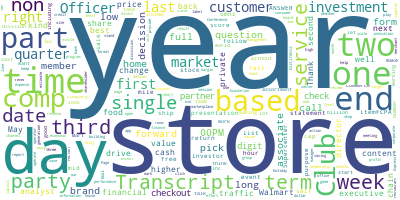

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(remain_token['token'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Preparing data for LDA

In [35]:
%%time
## need to optimize here
files["cleansed_tokens"] = files["tokens"].map(lambda x: [word for word in x if word in remain_token["token"].values])

Wall time: 2min 50s


In [41]:
files["cleansed_tokens"][0]

['WAL-MART',
 'STORES',
 'INC.',
 'NYSE',
 'WMT',
 'Fourth',
 'Quarter',
 'Fiscal',
 'Year',
 '2015',
 'Earnings',
 'Call',
 'February',
 '2015',
 'Management',
 'call',
 'recorded',
 'Carol',
 'Schumacher',
 'Wal-Mart',
 'Stores',
 'Inc',
 'Global',
 'Investor',
 'Relations',
 'Hello',
 'Carol',
 'Schumacher',
 'vice',
 'president',
 'global',
 'investor',
 'relations',
 'Wal-Mart',
 'Stores',
 'Inc',
 'Thanks',
 'joining',
 'today',
 'date',
 'call',
 'February',
 '2015',
 'call',
 'property',
 'Wal-Mart',
 'Stores',
 'Inc.',
 'intended',
 'use',
 'Walmart',
 'shareholders',
 'investment',
 'community',
 'reproduced',
 'way',
 'listening',
 'phone',
 'may',
 'navigate',
 'call',
 'follows',
 'Press',
 'key',
 'rewind',
 'playback',
 'seconds',
 'Press',
 'key',
 'pause',
 'resume',
 'playback',
 'Press',
 'key',
 'fast-forward',
 'playback',
 'seconds',
 'call',
 'contain',
 'statements',
 'Walmart',
 'believes',
 'forward-',
 'looking',
 'statements',
 'within',
 'meaning',
 'Privat

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA

files["corpe"] = files["cleansed_tokens"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(files["corpe"])

number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
walmart year sales quarter percent comp growth customers business stores

Topic #1:
reuters thomson stores inc wal mart going year customers walmart

Topic #2:
reuters thomson stores inc walmart think going wal mart really

Topic #3:
walmart inc think chief officer executive president vice financial factset

Topic #4:
year really think walmart business current going one company customers


## 12th Feb
- use tfidf instead of count vector

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(count_data)
tf_idf_vector = tfidf_transformer.transform(count_data)

In [38]:
tf_idf_vector.shape

(48, 4758)

In [39]:
number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(tf_idf_vector)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #1:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #2:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #3:
percent sales walmart quarter year comp growth increased results fiscal

Topic #4:
reuters walmart thomson think inc stores business going really year
